# Network weight analysis

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiment import Experiment
from analysis import MultiAnalysis, MultiRunAnalysis
from utils import print_stats
from scipy.stats import pearsonr, linregress, ranksums
from statsmodels.stats.proportion import proportions_ztest


data_path = "../data"
save_path = "../figs"

In [2]:
exp = Experiment.load_experiment(data_path, 'baseline/0')

In [3]:
net = exp.agent.actor
net.clamp_weights()

print("Bias stats:")
print_stats(net.b1)
print("\nWeight stats:")
print_stats(net.w1)
print("\nAggregated weight stats:")
print_stats(net.w1.sum(1))

Bias stats:
min   |max  |mean |std  |shape
-0.143|0.068|0.015|0.043|torch.Size([128])

Weight stats:
min   |max  |mean |std  |shape
0.000|11.546|0.923|0.946|torch.Size([128, 1000])

Aggregated weight stats:
min   |max  |mean |std  |shape
842.406|1093.026|923.482|83.142|torch.Size([128])


### L1 regularization effect

In [4]:
l1s = [f'l1_{n}' for n in ['1', '05', '01', '001', '0001', '00001', '000001', '0']]
l1s.insert(4, 'baseline')

In [6]:
ma = MultiAnalysis(data_path, l1s)

In [7]:
means, stds = ma.nonzero_weights()
for l1, mean, std in zip(l1s, means, stds):
    print(f"{l1}:\n  {mean:.03f} ± {std:.03f}")
    print()

l1_1:
  44.866 ± 29.875

l1_05:
  68.733 ± 29.788

l1_01:
  260.695 ± 36.699

l1_001:
  821.359 ± 41.104

baseline:
  901.298 ± 37.373

l1_0001:
  962.475 ± 32.738

l1_00001:
  970.330 ± 29.982

l1_000001:
  971.186 ± 30.311

l1_0:
  972.167 ± 28.810



In [8]:
l1s = [1, 0.5, 0.1, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0]

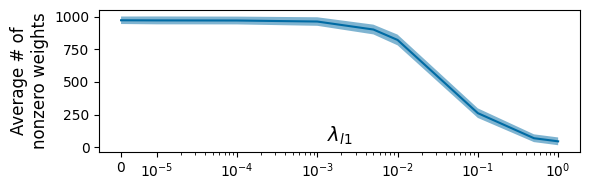

In [9]:
plt.figure(figsize=(6, 2))
plt.semilogx(l1s, means)
plt.fill_between(l1s, np.asarray(means) - stds, np.asarray(means) + stds, alpha=0.5)
plt.xscale('symlog', linthresh=1e-5, linscale=0.4, subs=range(2, 10))
plt.xlabel("$\\lambda_{l1}$", fontsize=14, labelpad=-40)
plt.ylabel("Average # of\nnonzero weights", fontsize=12)
plt.tight_layout()
plt.savefig("../figs/nonzero.png")
plt.show()

### Firing rate correlation

In [10]:
exp = Experiment.load_experiment(data_path, 'baseline/2')
net = exp.agent.actor
net.clamp_weights()

In [11]:
exp.compile_grid_cells(1)
exp.load_pfs()

In [12]:
idx = exp.pfs.get_place_cells().cpu()

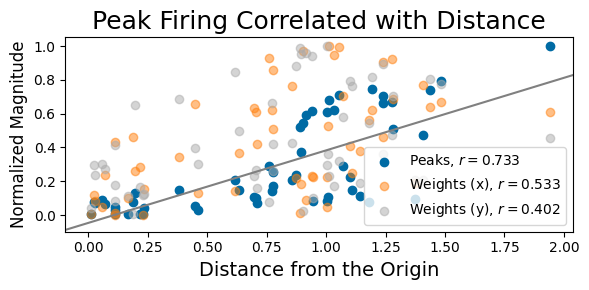

In [13]:
dists = exp.pfs.means[idx].detach().pow(2).sum(-1).cpu()
scales = exp.pfs.scales[idx].pow(2).detach().cpu()
w_x, w_y = net.lin2.weight.detach().abs().cpu()[2:,idx]

slope, intercept, rho, *_ = linregress(dists, scales.squeeze()/scales.max(), alternative='greater')

plt.figure(figsize=(6, 3))
plt.scatter(dists, scales/scales.max(), label=f'Peaks, $r={rho:.03}$')
plt.scatter(dists, w_x/w_x.max(), label=f'Weights (x), $r={pearsonr(w_x, dists).statistic:.03}$', alpha=0.5)
plt.scatter(dists, w_y/w_y.max(), label=f'Weights (y), $r={pearsonr(w_y, dists).statistic:.03}$', alpha=0.5)
plt.axline([0, intercept], slope=slope, c='gray')
plt.xlabel("Distance from the Origin", fontsize=14)
plt.ylabel("Normalized Magnitude", fontsize=12)
plt.title("Peak Firing Correlated with Distance", fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig("../figs/dist_corr.png")
plt.show()

In [14]:
print(pearsonr(dists, dists))
print(pearsonr(w_x, dists))
print(pearsonr(w_y, dists))

PearsonRResult(statistic=0.9999999, pvalue=3.445605731044788e-177)
PearsonRResult(statistic=0.5329623, pvalue=2.801504155153122e-05)
PearsonRResult(statistic=0.4015727, pvalue=0.0023754807183582506)


### Nonzero Weights to Inactive Cells

In [2]:
mra = MultiRunAnalysis(data_path, 'hidden500')

In [3]:
idx = [exp.pfs_per_env[1].get_active_cells_() for exp in mra.exps]

active = mra.get_weights()[torch.stack(idx)].cpu().flatten()
inactive = mra.get_weights()[~torch.stack(idx)].cpu().flatten()

counts = [(active.abs() > 0.001).sum().item(), (inactive.abs() > 0.001).sum().item()]
nobs = [active.shape.numel(), inactive.shape.numel()]

In [4]:
np.asarray(counts) / np.asarray(nobs)

array([0.87608108, 0.92365985])

In [5]:
proportions_ztest(counts, nobs)

(-113.11842145225461, 0.0)

In [6]:
[active.abs().mean().item(), inactive.abs().mean().item()]

[0.8664227724075317, 0.9516165852546692]

In [7]:
ranksums(active.abs(), inactive.abs())

RanksumsResult(statistic=-94.18131331162873, pvalue=0.0)